# Building a Face Recognition AI Model

## Import Libraries

In [1]:
import os

for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/LFW/archive/train/n000236/0336_02.jpg
input/LFW/archive/train/n000236/0399_01.jpg
input/LFW/archive/train/n000236/0416_01.jpg
input/LFW/archive/train/n000236/0048_01.jpg
input/LFW/archive/train/n000236/0381_01.jpg
input/LFW/archive/train/n000236/0220_01.jpg
input/LFW/archive/train/n000236/0132_01.jpg
input/LFW/archive/train/n000236/0383_01.jpg
input/LFW/archive/train/n000236/0244_01.jpg
input/LFW/archive/train/n000236/0024_06.jpg
input/LFW/archive/train/n000236/0460_01.jpg
input/LFW/archive/train/n000236/0436_01.jpg
input/LFW/archive/train/n000236/0245_01.jpg
input/LFW/archive/train/n000236/0490_02.jpg
input/LFW/archive/train/n000236/0007_01.jpg
input/LFW/archive/train/n000236/0002_01.jpg
input/LFW/archive/train/n000236/0046_01.jpg
input/LFW/archive/train/n000236/0224_01.jpg
input/LFW/archive/train/n000236/0195_01.jpg
input/LFW/archive/train/n000236/0239_01.jpg
input/LFW/archive/train/n000236/0247_02.jpg
input/LFW/archive/train/n000236/0106_01.jpg
input/LFW/archive/train/n000236/

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#hyperparameters
lr = 1e-2
batch_size = 64
num_epochs = 10

cuda


## Data Preparation

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    # Data Augmentation
    #     transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    #     transforms.RandomRotation(30),  # Random rotation within 30 degrees
    #     transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # Basic Transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

extracted_folder = 'input/LFW/lfw-deepfunneled/lfw-deepfunneled'
dataset = datasets.ImageFolder(root=extracted_folder, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {train_size}")
print(f"Number of testing samples: {test_size}")

Number of training samples: 10586
Number of testing samples: 2647


# Build Model

In [7]:
class GoogLeNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=1000):
        super(GoogLeNet, self).__init__()

        # Ensure aux_logits is a boolean
        assert isinstance(aux_logits, bool)
        self.aux_logits = aux_logits

        # Initial convolutional layer
        self.conv1 = conv_block(
            in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception blocks at different depths
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        # Global average pooling and dropout before final classification
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        # Auxiliary classifiers (used only during training)
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

    def forward(self, x):
        # Initial feature extraction
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        # Inception module stack
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        # Auxiliary classifier 1 (only during training)
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        # Auxiliary classifier 2 (only during training)
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        # Global Average Pooling and Fully Connected Layer
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        # Return auxiliary outputs during training, else only final output
        if self.aux_logits and self.training:
            return aux1, aux2, x
        else:
            return x


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        # 1x1 convolution branch
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        # Max pooling -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1),
        )

    def forward(self, x):
        # Concatenate outputs from all branches along depth axis
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        # Auxiliary classifier structure
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        # Convolution + Batch Normalization + ReLU Activation
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


In [8]:
model = GoogLeNet(aux_logits=True, num_classes=5749).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train Model

In [9]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if model.aux_logits:
            aux1, aux2, outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux1, labels)
            loss3 = criterion(aux2, labels)
            loss = loss1 + 0.5 * loss2 + 0.5 * loss3
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            train_losses.append(running_loss / 100)
            running_loss = 0.0

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print('Epoch %d: Training Accuracy: %.2f %%' % (epoch + 1, train_accuracy))

print('Finished Training')

[1,   100] loss: 17.595
Epoch 1: Training Accuracy: 3.32 %
[2,   100] loss: 15.930
Epoch 2: Training Accuracy: 4.04 %
[3,   100] loss: 15.614
Epoch 3: Training Accuracy: 4.04 %
[4,   100] loss: 15.430
Epoch 4: Training Accuracy: 4.04 %
[5,   100] loss: 15.346
Epoch 5: Training Accuracy: 4.06 %
[6,   100] loss: 15.211
Epoch 6: Training Accuracy: 4.12 %
[7,   100] loss: 15.059
Epoch 7: Training Accuracy: 4.13 %
[8,   100] loss: 14.928
Epoch 8: Training Accuracy: 4.33 %
[9,   100] loss: 14.778
Epoch 9: Training Accuracy: 4.59 %
[10,   100] loss: 14.738
Epoch 10: Training Accuracy: 5.14 %
Finished Training


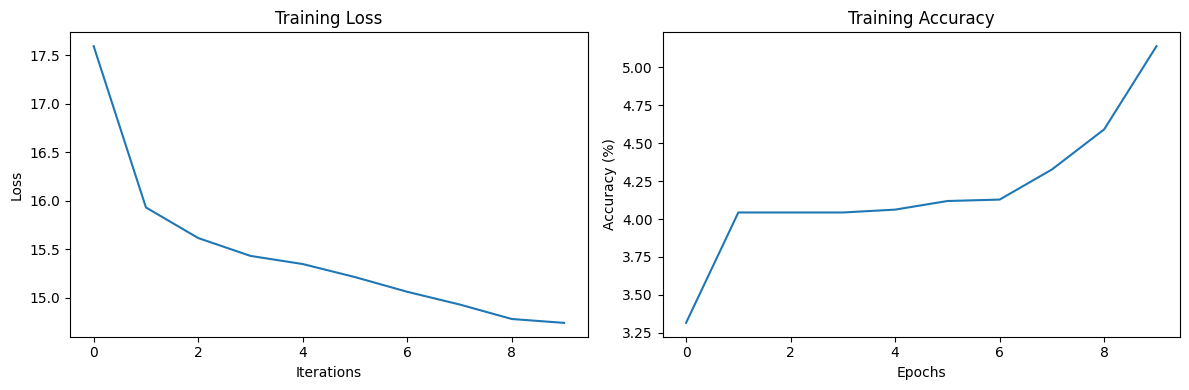

In [10]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Validate Model

In [11]:
model.eval()
correct = 0
total = 0


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print('Test Accuracy: %.2f %%' % (test_accuracy))

Test Accuracy: 5.14 %
